In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "gdrive/My Drive/Colab Notebooks/VinBrain_Intern/W2/1.SIIM-UNet"

/content/gdrive/My Drive/Colab Notebooks/VinBrain_Intern/W2/1.SIIM-UNet


In [ ]:
!pip install pydicom

In [ ]:
import torch
import numpy as np 
import pandas as pd 
import pydicom, cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import time
from torch.nn import functional as F
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
import torchvision
import torch.nn as nn
import torch.optim as optim

In [ ]:
df = pd.read_csv('preprocessing_data.csv')

In [ ]:
# decode rle into mask of XRays Image
def run_length_decode(rle, height = 1024, width = 1024, fill_value = 1):
    if rle == "-1": 
      return np.zeros((height, width), np.float32) # negative case
    # init mask matrix
    component = np.zeros((height, width), np.float32)
    # flatten init matrix into list
    component = component.reshape(-1)
    # processing rle
    rle = rle[1: -1] # ignore character "[", "]"
    # get all value from rle, store in tempString
    tempString = []
    for eachRLE in rle.split(','):
      s = eachRLE.replace('\'', '')
      tempString.extend([int(s) for s in s.strip().split(" ")])
    # convert into numpy array  
    rle = np.asarray(tempString)
    # convert rle into mask
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start + index
        end = start + length
        component[start: end] = fill_value # value in rle is idx of pixel 1 in matrix we want
        start = end
    # reshape into mask matrix with shape (width, height)
    component = component.reshape(width, height).T
    return component

In [ ]:
# return mask, image from .dcm and rle
def getMaskAndImg(dataframe, idx):
    ds = pydicom.dcmread(dataframe["filepath"][idx])
    img = ds.pixel_array # img is 2-D matrix
    mask = run_length_decode(dataframe["EncodedPixels"][idx]) # convert rle into mask
    img = np.stack((img, ) * 3, axis=-1) # get matrix shape (width, height, 3)
    return img, mask

In [ ]:
# transform image, by albumentation
class ImageTransform():
    def __init__(self, size, mean, std):
      self.transform = {
          "train": A.Compose([
                        A.HorizontalFlip(p=0.5),
                        A.ShiftScaleRotate(
                          shift_limit = 0,
                          scale_limit = 0.1,
                          rotate_limit = 10,
                          p = 0.5,
                          border_mode = cv2.BORDER_CONSTANT   
                        ),
                        A.GaussNoise(),
                        A.Resize(size, size),
                        A.Normalize(mean=mean, std=std, p = 1),
                        ToTensor()
                    ]),
          "val": A.Compose([
                        A.Resize(size, size), 
                        A.Normalize(mean=mean, std=std, p = 1),
                        ToTensor()
                  ])
      }
    def __call__(self, image, mask, phase):
      return self.transform[phase](image = image, mask = mask)

In [ ]:
# SIIM ACR
class SIIMDataset(Dataset):
    def __init__(self, dataframe, fnames, size, mean, std, phase = "train"):
        self.dataframe = dataframe
        self.fnames = fnames
        self.phase = phase
        self.transforms = ImageTransform(size, mean, std)

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        indice_inDataFrame = self.dataframe.index[self.dataframe['UID'] == image_id].tolist()[0]
        image, mask = getMaskAndImg(self.dataframe, indice_inDataFrame) # img, mask are arrays
        augmentedData = self.transforms(image = image, mask = mask, phase = self.phase)
        image = augmentedData['image']
        mask = augmentedData['mask']
        return image, mask 
    def __len__(self):
        return len(self.fnames)

In [ ]:
# sampled dataset
def sampledDataset(df, fold):
    df_positiveCase = df[df["Pneumothorax"] == 1]
    df_negativeCase = df[df["Pneumothorax"] == 0]
    df_negativeCase_sampled = df_negativeCase.sample(len(df_positiveCase) + 1000, random_state = 2019)
    newSub_Dataframe = pd.concat([df_positiveCase, df_negativeCase_sampled])
    kfold = StratifiedKFold(n_splits = 5, random_state = 43, shuffle = True)
    df_split = newSub_Dataframe
    # k_fold validation
    train_idx, val_idx = list(kfold.split(X = df_split["UID"], y = df_split["Pneumothorax"]))[fold]
    train_df, val_df = df_split.iloc[train_idx], df_split.iloc[val_idx]
    f_names_datatrain = train_df.iloc[:, 0].values.tolist()
    f_names_dataval = val_df.iloc[:, 0].values.tolist()
    size = 512
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_dataset = SIIMDataset(train_df, f_names_datatrain, size, mean, std, phase = "train")
    val_dataset = SIIMDataset(val_df, f_names_dataval, size, mean, std, phase = "val")
    return {
          "train": DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 4),
          "val":  DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 4)
      }

In [ ]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

In [ ]:
def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

In [ ]:
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

In [ ]:
def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [ ]:
def metric(probability, truth, threshold = 0.5, reduction = 'none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)
        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [ ]:
class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min = 0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
dataloader = sampledDataset(df, 2)
train_dataloader = dataloader["train"]
img, mask = next(iter(train_dataloader))

In [ ]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, chan_in, 
                       chan_out, 
                       padding = 1, 
                       kernel_size = 3, 
                       stride = 1
                ):
        super().__init__()
        self.conv = nn.Conv2d(chan_in, 
                              chan_out, 
                              padding = padding, 
                              kernel_size = kernel_size, 
                              stride = stride)
        self.bn = nn.BatchNorm2d(chan_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Bridge(nn.Module):
    def __init__(self, chan_in, chan_out):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(chan_in, chan_out),
            ConvBlock(chan_out, chan_out)
        )

    def forward(self, x):
        return self.bridge(x)

In [ ]:
class UpBlock(nn.Module):    
    def __init__(self, chan_in, 
                       chan_out, 
                       upconv_in = None, 
                       upconv_out = None,
                ):
        super().__init__()
        if upconv_in == None:
            upconv_in = chan_in
        if upconv_out == None:
            upconv_out = chan_out
        self.upsample = nn.ConvTranspose2d(upconv_in, upconv_out, kernel_size = 2, stride = 2)
        self.conv = nn.Sequential(ConvBlock(chan_in, chan_out),
                                  ConvBlock(chan_out, chan_out))

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x1 = torch.cat([x1, x2], 1)
        x1 = self.conv(x1)
        return x1

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained = True)
        # conv -> batchnorm -> reLU
        self.module0 = nn.Sequential(*list(resnet.children()))[:3] 
        # max pool layer in resnet
        self.module0pool = list(resnet.children())[3] 
        # collect bottleneck in resnet to use as block module in Unet
        encoder = []
        # there are 4 module nn.Sequential in Resnet50
        for module in list(resnet.children()):
            if isinstance(module, nn.Sequential):
                encoder.append(module)
        self.encoder = nn.ModuleList(encoder)
        self.bridge = Bridge(2048, 2048)

        self.decoder = nn.ModuleList([
            UpBlock(2048, 1024),
            UpBlock(1024, 512),
            UpBlock(512, 256),
            UpBlock(192, 128, 256, 128),
            UpBlock(67, 64, 128, 64)
        ])
        self.outLayer = nn.Conv2d(64, 1, kernel_size = 1, stride = 1)

    def forward(self, x):
        tempStorage = dict()
        tempStorage["t_0"] = x
        # x.size(): 3x512x512
        x = self.module0(x)
        # x.size(): 64x256x256
        tempStorage["t_1"] = x
        x = self.module0pool(x)
        # x.size():64x128x128
        for idx, module in enumerate(self.encoder, start = 2):
            x = module(x)
            # 2, 3, 4, 5
            if idx == 5: 
                continue
            tempStorage[f"t_{idx}"] = x

        x = self.bridge(x)

        for idx, module in enumerate(self.decoder, start = 1):
            match_indice = 5 - idx
            temp_key = f"t_{match_indice}"
            x = module(x, tempStorage[temp_key])
        x = self.outLayer(x)
        return x

In [ ]:
model = UNet()
fold = 2
total_folds = 5
lr = 5e-4
num_epochs = 20
best_loss = float("inf")
device = torch.device("cuda:0")
torch.set_default_tensor_type("torch.cuda.FloatTensor")
criterion = MixedLoss(0.3, 3.5)
optimizer = optim.Adam( model.parameters(), lr = lr)
model_path = './model_epoch59_v3.pth'
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict["state_dict"])
model.to(device = device)
accumulation_steps = 32 // 4
best_loss = state_dict["best_loss"]

In [ ]:
losses = {phase: [] for phase in ["train", "val"]}
iou_scores = {phase: [] for phase in ["train", "val"]}
dice_scores = {phase: [] for phase in ["train", "val"]}

In [ ]:
for epoch in range(num_epochs):
    meter = Meter("train", epoch)
    start = time.strftime("%H:%M:%S")
    model.train(True)
    running_loss = 0.0
    optimizer.zero_grad()
    dataloader = sampledDataset(df, 2)
    train_dataloader = dataloader["train"]
    val_dataloader = dataloader["val"]
    total_batches = len(train_dataloader)
    for itr, batch in enumerate(train_dataloader):
        images, targets = batch
        images = images.to(device)
        masks = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss = loss / accumulation_steps    
        loss.backward()
        if (itr + 1 ) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        running_loss += loss.item()
        outputs = outputs.detach().cpu()
        meter.update(targets, outputs)

    epoch_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log("train", epoch, epoch_loss, meter, start)
    losses["train"].append(epoch_loss)
    dice_scores["train"].append(dice)
    iou_scores["train"].append(iou)
    torch.cuda.empty_cache()

    meter = Meter("val", epoch)
    start = time.strftime("%H:%M:%S")
    model.train(False)
    running_loss = 0.0
    total_batches = len(val_dataloader)
    optimizer.zero_grad()
    for itr, batch in enumerate(val_dataloader):
        images, targets = batch
        images = images.to(device)
        masks = targets.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss = loss / accumulation_steps    
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)

    epoch_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log("val", epoch, epoch_loss, meter, start)
    losses["val"].append(epoch_loss)
    dice_scores["val"].append(dice)
    iou_scores["val"].append(iou)
    torch.cuda.empty_cache()
    if epoch_loss < best_loss:
        print("-------OH YEAH---------")
        best_loss = epoch_loss
        state = {
                "epoch": epoch,
                "best_loss": best_loss,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
        }
        print("-----------------------")
        torch.save(state, "./model_v3_1.pth")
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 1.9932 | dice: 0.5545 | dice_neg: 0.6465 | dice_pos: 0.3665 | IoU: 0.2980
Loss: 4.5928 | dice: 0.4415 | dice_neg: 0.2800 | dice_pos: 0.1633 | IoU: 0.2770
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.0476 | dice: 0.5460 | dice_neg: 0.6311 | dice_pos: 0.3719 | IoU: 0.3034
Loss: 3.9604 | dice: 0.5708 | dice_neg: 0.4148 | dice_pos: 0.1578 | IoU: 0.2727
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 1.9854 | dice: 0.5490 | dice_neg: 0.6281 | dice_pos: 0.3664 | IoU: 0.3026
Loss: 3.3158 | dice: 0.6186 | dice_neg: 0.4913 | dice_pos: 0.1292 | IoU: 0.2166
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.0533 | dice: 0.5597 | dice_neg: 0.6547 | dice_pos: 0.3662 | IoU: 0.3014
Loss: 3.3283 | dice: 0.6243 | dice_neg: 0.5118 | dice_pos: 0.1144 | IoU: 0.1923



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.0978 | dice: 0.5624 | dice_neg: 0.6655 | dice_pos: 0.3666 | IoU: 0.3009
Loss: 4.0345 | dice: 0.6047 | dice_neg: 0.4606 | dice_pos: 0.1460 | IoU: 0.2523



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.1856 | dice: 0.5440 | dice_neg: 0.6294 | dice_pos: 0.3515 | IoU: 0.2888
Loss: 4.1278 | dice: 0.5484 | dice_neg: 0.3927 | dice_pos: 0.1574 | IoU: 0.2687



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.2221 | dice: 0.5287 | dice_neg: 0.6215 | dice_pos: 0.3412 | IoU: 0.2775
Loss: 3.9528 | dice: 0.5295 | dice_neg: 0.4014 | dice_pos: 0.1299 | IoU: 0.2139



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.1788 | dice: 0.5278 | dice_neg: 0.6156 | dice_pos: 0.3414 | IoU: 0.2760
Loss: 4.2237 | dice: 0.5672 | dice_neg: 0.4046 | dice_pos: 0.1636 | IoU: 0.2789



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.0808 | dice: 0.5214 | dice_neg: 0.5846 | dice_pos: 0.3618 | IoU: 0.2936
Loss: 4.0505 | dice: 0.5812 | dice_neg: 0.4085 | dice_pos: 0.1744 | IoU: 0.3068



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


Loss: 2.1660 | dice: 0.5498 | dice_neg: 0.6341 | dice_pos: 0.3536 | IoU: 0.2931
Loss: 3.6263 | dice: 0.5959 | dice_neg: 0.4424 | dice_pos: 0.1552 | IoU: 0.2652



In [ ]:
print("-------OH YEAH---------")
best_loss = losses["val"][-1]
state = {
        "epoch": 9,
        "best_loss": best_loss,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
}
print("-----------------------")
torch.save(state, "./model_epoch9_v3_1.pth")

-------OH YEAH---------
-----------------------


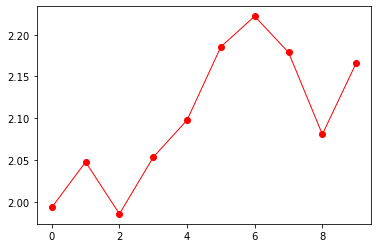

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(10).tolist(), losses["train"], 'ro-', label='line 1', linewidth=1)

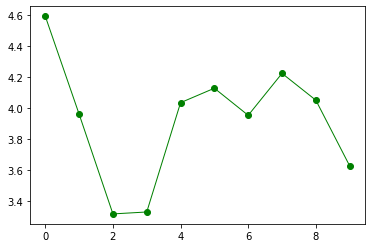

In [ ]:
plt.plot(np.arange(10).tolist(), losses["val"], 'go-', label='line 1', linewidth=1)

In [ ]:
import torch
import os
import numpy as np 
import pandas as pd 
import pydicom, cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
import torchvision
import torch.nn as nn
import torch.optim as optim

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = A.Compose(
            [
                A.Normalize(mean = mean, std = std, p = 1),
                A.Resize(size, size),
                ToTensor()
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".dcm")
        ds = pydicom.dcmread(path)
        image = ds.pixel_array
        image = np.stack((image, ) * 3, axis=-1)
        images = self.transform(image = image)["image"]
        return images

    def __len__(self):
        return self.num_samples

In [ ]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [ ]:
model = UNetWithResnet50Encoder()
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 4
best_threshold = 0.5
min_size = 3500
device = torch.device("cpu")
df = pd.read_csv("./stage_2_sample_submission.csv")
model.to(device)
testset = DataLoader(
    TestDataset("stage_2_images", df, size, mean, std),
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)
model.eval()
state = torch.load('./model_epoch9_v3_1.pth', map_location = lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []

for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission_v1.csv', columns=['ImageId', 'EncodedPixels'], index=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 50%|████▉     | 398/802 [1:06:33<1:08:15, 10.14s/it]